# 02 | Advanced Models

**Objective:**  
Train advanced ensemble models—Random Forest, XGBoost, LightGBM on the fully engineered dataset to evaluate performance gains over the logistic regression baseline.

**Approach:**  
- Use the fully engineered feature set to leverage interactions, binning, and transformations.
- Train Random Forest, XGBoost, and LightGBM models using 5-fold stratified cross-validation to ensure robust evaluation.
- Assess performance using ROC-AUC, PR-AUC, F1 score, and confusion matrix.
- Interpret results through feature importance rankings from each model to understand key predictors.

In [11]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay

## Load Engineered Dataset  
We’ll pull from our `credit_risk_engineered` table in the SQLite DB.

In [12]:
conn = sqlite3.connect("../data/loanvet.db")
df = pd.read_sql_query("SELECT * FROM credit_risk_engineered", conn)
conn.close()
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,TotalDelinquencies_log,HighUtilizationFlag,IncomePerCreditLine,AgeGroup_MidAge,AgeGroup_Senior,DependentsGroup_Small,DependentsGroup_Large,Util_x_Late,IncomePerDependent,CreditLines_x_Delinquencies
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,1.098612,0,651.428571,1,0,1,0,0.000000,3040.0,26
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,0.000000,1,520.000000,1,0,1,0,0.000000,1300.0,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,1.098612,0,1014.000000,1,0,0,0,0.350539,3042.0,4
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0.000000,0,550.000000,1,0,0,0,0.000000,3300.0,0
4,0,0.907239,49,1,0.024926,50000.0,7,0,1,0,...,0.693147,1,6250.000000,1,0,0,0,0.000000,50000.0,7


## Drop Redundant Columns

In [13]:
drop_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse",
    'NumberOfTime30-59DaysPastDueNotWorse_log',
    'NumberOfTimes90DaysLate_log',
    'NumberOfTime60-89DaysPastDueNotWorse_log',
    "TotalDelinquencies",
    "MonthlyIncome"
]
df = df.drop(columns=drop_cols, errors="ignore")

## Data Preprocessing Notes
To reduce multicollinearity and avoid redundancy, we dropped raw features that were either highly skewed or already represented by transformed versions:

- Original delinquency variables (e.g., `NumberOfTimes90DaysLate`) were replaced by their log-transformed versions or aggregated into `TotalDelinquencies_log`.
- Skewed continuous variables like `RevolvingUtilizationOfUnsecuredLines` and `MonthlyIncome` were dropped in favor of their log-transformed counterparts.
- The original `TotalDelinquencies` was also removed since the log-transformed version was used for modeling.

This step ensures the model focuses on cleaner, more interpretable signals while minimizing the risk of redundant information.

## Train/Test Split
Stratify on the target to preserve imbalance.

In [14]:
X = df.drop(columns=["SeriousDlqin2yrs"])
y = df["SeriousDlqin2yrs"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Random Forest Classifier
Train a Random Forest model with balanced class weights to handle class imbalance. The model uses 100 trees (n_estimators=100) and a fixed random state for reproducibility. Predicted probabilities for the positive class are generated for performance evaluation.

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
rf_y_pred_prob = rf.predict_proba(X_test)[:,1]

rf_y_pred = (rf_y_pred_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, rf_y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, rf_y_pred_prob)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, rf_y_pred)

print(f"Train/Test Split ROC-AUC: {roc_auc:.4f}")
print(f"Train/Test Split PR-AUC: {pr_auc:.4f}")
print(f"Train/Test Split F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, rf_y_pred)
print("Train/Test Split Confusion Matrix:")
print(cm)


Train/Test Split ROC-AUC: 0.8362
Train/Test Split PR-AUC: 0.3549
Train/Test Split F1 Score: 0.2635
Train/Test Split Confusion Matrix:
[[27599   278]
 [ 1656   346]]


## XGBoost Classifier
Train an XGBoost model using 100 trees with a maximum depth of 3 and a learning rate of 0.1. The model is optimised with the logistic loss (logloss) metric. Predicted probabilities for the positive class are generated for performance evaluation.

In [16]:
xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_y_pred_prob = xgb.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, xgb_y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, xgb_y_pred_prob)

xgb_y_pred = (xgb_y_pred_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, xgb_y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, xgb_y_pred_prob)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, xgb_y_pred)

print(f"Train/Test Split ROC-AUC: {roc_auc:.4f}")
print(f"Train/Test Split PR-AUC: {pr_auc:.4f}")
print(f"Train/Test Split F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, xgb_y_pred)
print("Train/Test Split Confusion Matrix:")
print(cm)


Train/Test Split ROC-AUC: 0.8637
Train/Test Split PR-AUC: 0.4029
Train/Test Split F1 Score: 0.2826
Train/Test Split Confusion Matrix:
[[27618   259]
 [ 1630   372]]


## LightGBM Classifier
Train a LightGBM model using 100 trees with a maximum depth of 3 and a learning rate of 0.1. The model is optimised with the binary logistic loss function. Predicted probabilities for the positive class are generated for performance evaluation.

In [17]:
lgbm = LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)
lgbm_y_pred_prob = lgbm.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, lgbm_y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, lgbm_y_pred_prob)

lgbm_y_pred = (lgbm_y_pred_prob >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, lgbm_y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, lgbm_y_pred_prob)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, lgbm_y_pred)

print(f"Train/Test Split ROC-AUC: {roc_auc:.4f}")
print(f"Train/Test Split PR-AUC: {pr_auc:.4f}")
print(f"Train/Test Split F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, lgbm_y_pred)
print("Train/Test Split Confusion Matrix:")
print(cm)


[LightGBM] [Info] Number of positive: 8007, number of negative: 111505
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 119512, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train/Test Split ROC-AUC: 0.8633
Train/Test Split PR-AUC: 0.3986
Train/Test Split F1 Score: 0.3452
Train/Test Split Confusion Matrix:
[[22462  5415]
 [  455  1547]]


### Preliminary Train/Test Split Evaluation

Before performing more robust cross-validation, we conduct an initial evaluation using a single train/test split.

- This quick check ensures our pipeline works end-to-end without errors.
- However, metrics from a single split can be unstable and heavily dependent on how the data is divided.
- Therefore, these results serve as a sanity check rather than a final performance measure.

For reliable and generalizable model evaluation, we proceed with stratified 5-fold cross-validation, which averages performance across multiple splits and reduces variance due to random sampling.

## Performance Metrics  

Evaluate model using key classification metrics that reflect imbalanced data performance:

ROC-AUC: Measures overall ranking ability between classes.

PR-AUC: Focuses on precision and recall trade-off, important for imbalanced datasets.

F1 Score: Harmonic mean of precision and recall at 0.5 threshold.

Confusion Matrix: Summarizes true positives, false positives, true negatives, and false negatives across folds.

In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_roc_auc_scores, rf_pr_auc_scores, rf_f1_scores = [], [], []
xgb_roc_auc_scores, xgb_pr_auc_scores, xgb_f1_scores = [], [], []
lgb_roc_auc_scores, lgb_pr_auc_scores, lgb_f1_scores = [], [], []

rf_cm_sum = np.array([[0, 0], [0, 0]])
xgb_cm_sum = np.array([[0, 0], [0, 0]])
lgb_cm_sum = np.array([[0, 0], [0, 0]])

def calc_metrics(y_true, y_scores, threshold=0.5):
    roc_auc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    y_pred = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return roc_auc, pr_auc, f1, cm

for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    rf_pred_prob = rf.predict_proba(X_test)[:, 1]

    # XGBoost
    xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1,
                        eval_metric='logloss', random_state=42)
    xgb.fit(X_train, y_train)
    xgb_pred_prob = xgb.predict_proba(X_test)[:, 1]

    # LightGBM
    lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1,
                        random_state=42)
    lgb.fit(X_train, y_train)
    lgb_pred_prob = lgb.predict_proba(X_test)[:, 1]

    # Calculate metrics
    rf_roc, rf_pr, rf_f1, rf_cm = calc_metrics(y_test, rf_pred_prob)
    xgb_roc, xgb_pr, xgb_f1, xgb_cm = calc_metrics(y_test, xgb_pred_prob)
    lgb_roc, lgb_pr, lgb_f1, lgb_cm = calc_metrics(y_test, lgb_pred_prob)

    rf_roc_auc_scores.append(rf_roc)
    rf_pr_auc_scores.append(rf_pr)
    rf_f1_scores.append(rf_f1)
    rf_cm_sum += rf_cm

    xgb_roc_auc_scores.append(xgb_roc)
    xgb_pr_auc_scores.append(xgb_pr)
    xgb_f1_scores.append(xgb_f1)
    xgb_cm_sum += xgb_cm

    lgb_roc_auc_scores.append(lgb_roc)
    lgb_pr_auc_scores.append(lgb_pr)
    lgb_f1_scores.append(lgb_f1)
    lgb_cm_sum += lgb_cm

    if fold_idx == skf.get_n_splits(X, y) - 1:
        last_fold = {
            'y_test': y_test,
            'rf_prob': rf_pred_prob,
            'xgb_prob': xgb_pred_prob,
            'lgb_prob': lgb_pred_prob
        }

print(f"Random Forest ROC-AUC: {np.mean(rf_roc_auc_scores):.4f} ± {np.std(rf_roc_auc_scores):.4f}")
print(f"Random Forest PR-AUC: {np.mean(rf_pr_auc_scores):.4f} ± {np.std(rf_pr_auc_scores):.4f}")
print(f"Random Forest F1: {np.mean(rf_f1_scores):.4f} ± {np.std(rf_f1_scores):.4f}")
print(f"Random Forest Summed Confusion Matrix:\n{rf_cm_sum}\n")

print(f"XGBoost ROC-AUC: {np.mean(xgb_roc_auc_scores):.4f} ± {np.std(xgb_roc_auc_scores):.4f}")
print(f"XGBoost PR-AUC: {np.mean(xgb_pr_auc_scores):.4f} ± {np.std(xgb_pr_auc_scores):.4f}")
print(f"XGBoost F1: {np.mean(xgb_f1_scores):.4f} ± {np.std(xgb_f1_scores):.4f}")
print(f"XGBoost Summed Confusion Matrix:\n{xgb_cm_sum}\n")

print(f"LightGBM ROC-AUC: {np.mean(lgb_roc_auc_scores):.4f} ± {np.std(lgb_roc_auc_scores):.4f}")
print(f"LightGBM PR-AUC: {np.mean(lgb_pr_auc_scores):.4f} ± {np.std(lgb_pr_auc_scores):.4f}")
print(f"LightGBM F1: {np.mean(lgb_f1_scores):.4f} ± {np.std(lgb_f1_scores):.4f}")
print(f"LightGBM Summed Confusion Matrix:\n{lgb_cm_sum}")

[LightGBM] [Info] Number of positive: 8007, number of negative: 111505
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1814
[LightGBM] [Info] Number of data points in the train set: 119512, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066997 -> initscore=-2.633753
[LightGBM] [Info] Start training from score -2.633753
[LightGBM] [Info] Number of positive: 8007, number of negative: 111506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1813
[LightGBM] [Info] Number of data points in the train set: 119513, number of used features: 19
[LightGBM] [Info

## ROC-AUC and Precision-Recall Curves

To visually compare model performance, we plot the ROC and Precision-Recall curves for the final fold of cross-validation. These plots provide insight into each model's ability to separate the positive and negative classes, especially in the context of class imbalance.

- **ROC Curve**: Shows the trade-off between true positive rate and false positive rate. A higher curve indicates better discriminative ability.
- **Precision-Recall Curve**: More informative for imbalanced datasets, highlighting how well the model maintains precision across recall levels.

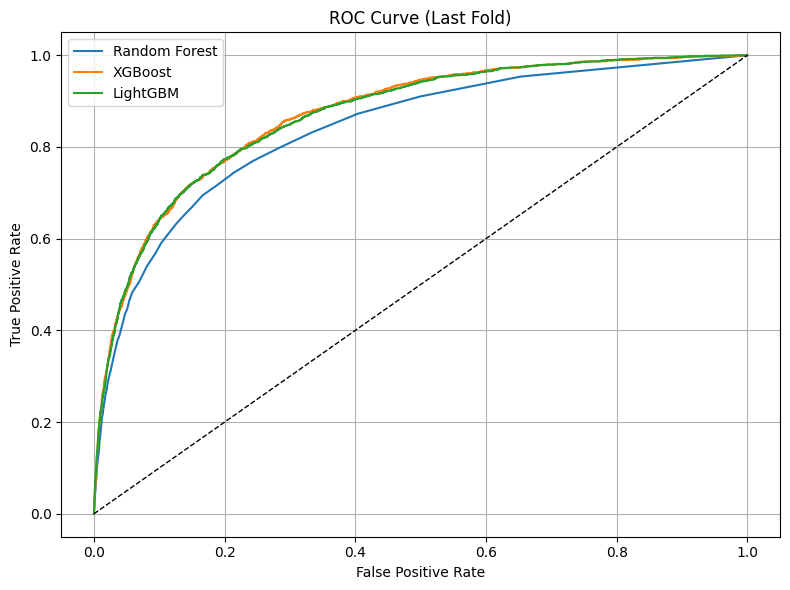

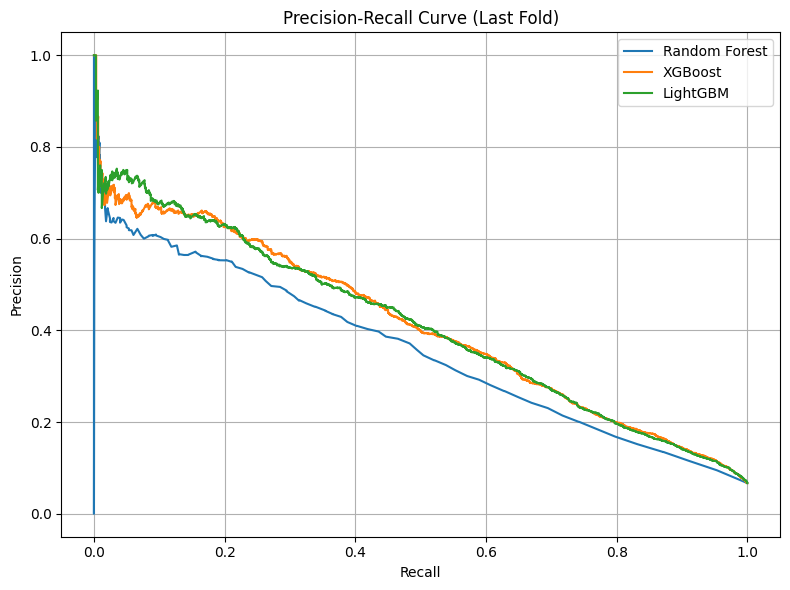

In [19]:
y_test = last_fold['y_test']
plt.figure(figsize=(8, 6))
for label, prob in [('Random Forest', last_fold['rf_prob']),
                    ('XGBoost', last_fold['xgb_prob']),
                    ('LightGBM', last_fold['lgb_prob'])]:
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=label)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Last Fold)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for label, prob in [('Random Forest', last_fold['rf_prob']),
                    ('XGBoost', last_fold['xgb_prob']),
                    ('LightGBM', last_fold['lgb_prob'])]:
    precision, recall, _ = precision_recall_curve(y_test, prob)
    plt.plot(recall, precision, label=label)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Last Fold)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Model Performance Interpretation

#### Random Forest

- **ROC-AUC (0.8313 ± 0.0048)**  
  The model has good discrimination ability between defaulters and non-defaulters, but is the weakest among the three models here.

- **PR-AUC (0.3446 ± 0.0115)**  
  Precision-recall performance is moderate, reflecting the challenge of predicting the minority (positive) class in this imbalanced dataset.

- **F1 Score (0.2466 ± 0.0053)**  
  The harmonic mean of precision and recall is relatively low, indicating a conservative model with more false negatives or false positives.

#### XGBoost

- **ROC-AUC (0.8647 ± 0.0037)**  
Strong discrimination ability, best among the three models.

- **PR-AUC (0.3988 ± 0.0109)**  
Better precision-recall performance, indicating improved detection of the minority class.

- **F1 Score (0.2888 ± 0.0063)**  
Better balance between precision and recall compared to Random Forest.

#### LightGBM

- **ROC-AUC (0.8636 ± 0.0035)**  
Comparable discrimination to XGBoost, slightly behind by a very small margin.

- **PR-AUC (0.3965 ± 0.0112)**  
Similar precision-recall performance as XGBoost, indicating competitive detection of the minority class.

- **F1 Score (0.2851 ± 0.0087)**  
Balanced precision and recall close to XGBoost, with slightly lower F1.

## Conclusions

- All three models show **strong ROC-AUC** (~0.83–0.86), meaning good overall ranking ability.
- **XGBoost and LightGBM outperform Random Forest** in precision-recall and F1 metrics, indicating better handling of class imbalance.
- Despite strong metrics, **false negatives remain substantial** (~8,100+).

In [23]:
import os
import joblib
import json

# Define directory to save advanced models artifacts
save_dir = '../models/advanced'
os.makedirs(save_dir, exist_ok=True)

# Save models individually
joblib.dump(rf, os.path.join(save_dir, 'random_forest.pkl'))
joblib.dump(xgb, os.path.join(save_dir, 'xgboost.pkl'))
joblib.dump(lgb, os.path.join(save_dir, 'lightgbm.pkl'))

# Save average cross-validation metrics
metrics = {
    'random_forest': {
        'roc_auc_mean': np.mean(rf_roc_auc_scores),
        'roc_auc_std': np.std(rf_roc_auc_scores),
        'pr_auc_mean': np.mean(rf_pr_auc_scores),
        'pr_auc_std': np.std(rf_pr_auc_scores),
        'f1_mean': np.mean(rf_f1_scores),
        'f1_std': np.std(rf_f1_scores),
        'confusion_matrix_sum': rf_cm_sum.tolist()
    },
    'xgboost': {
        'roc_auc_mean': np.mean(xgb_roc_auc_scores),
        'roc_auc_std': np.std(xgb_roc_auc_scores),
        'pr_auc_mean': np.mean(xgb_pr_auc_scores),
        'pr_auc_std': np.std(xgb_pr_auc_scores),
        'f1_mean': np.mean(xgb_f1_scores),
        'f1_std': np.std(xgb_f1_scores),
        'confusion_matrix_sum': xgb_cm_sum.tolist()
    },
    'lightgbm': {
        'roc_auc_mean': np.mean(lgb_roc_auc_scores),
        'roc_auc_std': np.std(lgb_roc_auc_scores),
        'pr_auc_mean': np.mean(lgb_pr_auc_scores),
        'pr_auc_std': np.std(lgb_pr_auc_scores),
        'f1_mean': np.mean(lgb_f1_scores),
        'f1_std': np.std(lgb_f1_scores),
        'confusion_matrix_sum': lgb_cm_sum.tolist()
    }
}

with open(os.path.join(save_dir, 'cv_metrics.json'), 'w') as f:
    json.dump(metrics, f, indent=4)

# Save feature list for inference
feature_list = X.columns.tolist()
with open(os.path.join(save_dir, 'feature_list.json'), 'w') as f:
    json.dump(feature_list, f, indent=4)

#Save feature importance
for model_name, model in [('random_forest', rf), ('xgboost', xgb), ('lightgbm', lgb)]:
    if model_name == 'lightgbm':
        # Get gain-based importance and normalise
        importance = model.booster_.feature_importance(importance_type='gain')
        importance = importance / importance.sum()
    else:
        # For RF and XGB, use feature_importances_ directly
        importance = model.feature_importances_
        # Normalize to sum to 1 for consistency
        importance = importance / importance.sum()
    
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importance,
        'abs_importance': np.abs(importance)  # redundant but keeps format consistent
    }).sort_values(by='importance', ascending=False)
    
    path = os.path.join(save_dir, f'{model_name}_feature_importance.csv')
    importance_df.to_csv(path, index=False)

print(f"Advanced ensemble models and metrics saved successfully in '{save_dir}'")


Advanced ensemble models and metrics saved successfully in '../models/advanced'
